In [2]:
import sys
import os
sys.path.append(os.path.abspath('../ETL_pipeline'))
from get_data_from_cloud import get_dataframe_from_cloud
from dotenv import load_dotenv
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

load_dotenv()
MONGO_URI = os.getenv('MONGO_URI')
client = MongoClient(MONGO_URI, server_api=ServerApi('1'))

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)
    
df = get_dataframe_from_cloud(client=client, db_name="data", collection_name='emissions')

Pinged your deployment. You successfully connected to MongoDB!
Pinged your deployment. You successfully connected to MongoDB!


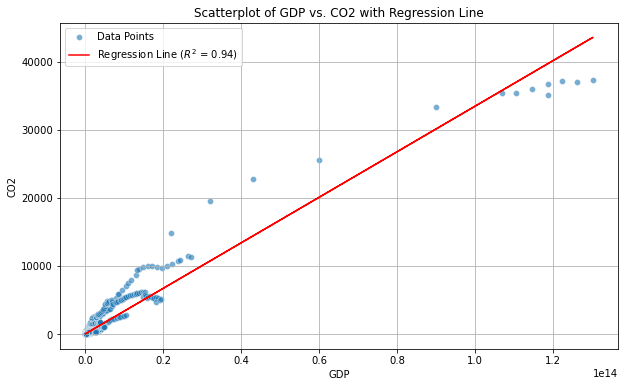

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cleaned_data = df[~((df['gdp'] == 0) | (df['gdp'].isna()) | (df['gdp'] == ''))]
gdp = cleaned_data['gdp']
co2_emissions = cleaned_data['co2']

X = gdp.values.reshape(-1, 1)
y = co2_emissions.values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# calculate R^2
r_squared = r2_score(y, y_pred)

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=gdp, y=co2_emissions, alpha=0.6, label='Data Points')
plt.plot(gdp, y_pred, color='red', label=f'Regression Line ($R^2$ = {r_squared:.2f})')
plt.title('Scatterplot of GDP vs. CO2 with Regression Line')
plt.xlabel('GDP')
plt.ylabel('CO2')
plt.legend()
plt.grid()
plt.show()

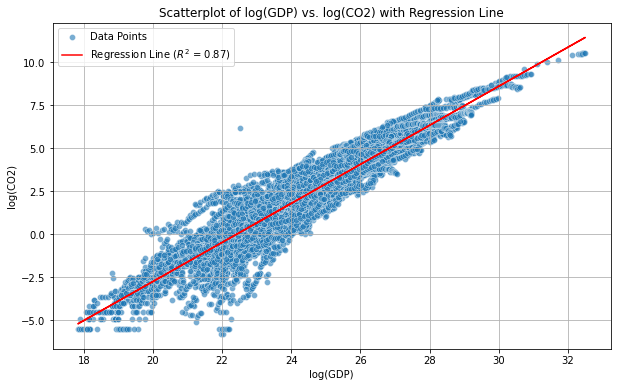

In [4]:
import numpy as np

# filter non-positive GDP or CO2 consumption
cleaned_data = cleaned_data[(cleaned_data['gdp'] > 0) & (cleaned_data['co2'] > 0)]

# log-transform the data
cleaned_data['log_gdp'] = np.log(cleaned_data['gdp'])
cleaned_data['log_co2'] = np.log(cleaned_data['co2'])

# log-transformed data regression
log_gdp = cleaned_data['log_gdp']
log_co2 = cleaned_data['log_co2']
X_log = log_gdp.values.reshape(-1, 1)
y_log = log_co2.values

# linear regression on log-transformed data
model_log = LinearRegression()
model_log.fit(X_log, y_log)
y_pred_log = model_log.predict(X_log)

# calculate R^2
r_squared_log = r2_score(y_log, y_pred_log)

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log_gdp, y=log_co2, alpha=0.6, label='Data Points')
plt.plot(log_gdp, y_pred_log, color='red', label=f'Regression Line ($R^2$ = {r_squared_log:.2f})')
plt.title('Scatterplot of log(GDP) vs. log(CO2)')
plt.xlabel('log(GDP)')
plt.ylabel('log(CO2)')
plt.legend()
plt.grid()

plt.show()

In [9]:
import numpy as np

def calculate_correlation(x, y):
    return np.corrcoef(x, y)[0, 1]

# parameters for bootstrapping
n_iterations = 10000 
correlations = []

# bootstrapping process
np.random.seed(42)
for _ in range(n_iterations):
    indices = np.random.choice(len(log_gdp), len(log_gdp), replace=True)
    resampled_log_gdp = log_gdp.values[indices]
    resampled_log_co2 = log_co2.values[indices]
    correlations.append(calculate_correlation(resampled_log_gdp, resampled_log_co2))

# calculate 95% confidence interval
lower_bound = np.percentile(correlations, 2.5)
upper_bound = np.percentile(correlations, 97.5)

# observed correlation
observed_correlation = calculate_correlation(log_gdp, log_co2)

print(f"Observed Correlation: {observed_correlation:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

Observed Correlation: 0.9346
95% Confidence Interval: [0.9320, 0.9372]


Looking at the relationship between the GDP and CO2 emissions of each country, we initially saw a logistic relationship between the two variables. Because of this, we transformed the two variables with a log transformation. Looking at the scatterplot with the transformed variables, we see the linearity has improved. We then looked at the R squared, or correlation, of this scatterplot. Using this value, we calculated a confidence interval using bootstrapping. We used a 95% confidence level, and even at this high level of confidence, the interval was quite narrow. The values inside the interval were also quite high, so we believe that the correlation between GDP and CO2 emissions of countries is positive and very strong.

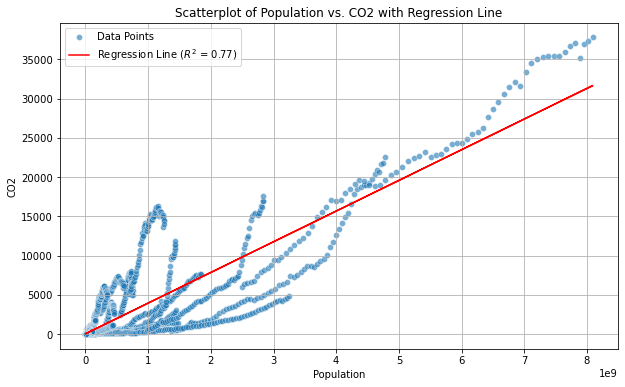

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd

#remove missing or zero population values
cleaned_data = df[~((df['population'] == 0) | (df['population'].isna()))]

population = cleaned_data['population']
co2_emissions = cleaned_data['co2']

#prepare data for regression
X = population.values.reshape(-1, 1)
y = co2_emissions.values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

#R^2
r_squared = r2_score(y, y_pred)

#plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=population, y=co2_emissions, alpha=0.6, label='Data Points')
plt.plot(population, y_pred, color='red', label=f'Regression Line ($R^2$ = {r_squared:.2f})')
plt.title('Scatterplot of Population vs. CO2')
plt.xlabel('Population')
plt.ylabel('CO2')
plt.legend()
plt.grid()
plt.show()